In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler


In [14]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 3.0 MB/s  0:00:03m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load Grenoble apartment CSV from project folder
from pathlib import Path
candidates = [
    Path('../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
    Path('projet_dvf/DataPreprocessing/PreprocessedData/df_grenoble_vente.csv'),
]
csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    tried = [str((Path.cwd()/p).resolve()) if not p.is_absolute() else str(p) for p in candidates]
    raise FileNotFoundError(f'Missing file. Tried: {tried}')
df = pd.read_csv(csv_path)
print(f'Loaded {len(df):,} rows and {len(df.columns)} columns from {csv_path}')
df.head()

Loaded 1,288 rows and 7 columns from ../DataPreprocessing/PreprocessedData/df_grenoble_vente.csv


,price,type_local,surface_bati,surface_terrain,date,nb_pieces,type_local_1234
0,112560.0,Appartement,45.0,1.0,10,2,1
1,65000.0,Appartement,29.0,1.0,8,1,1
2,9000.0,Local industriel. commercial ou assimilé,12.0,1.0,9,0,3
3,133000.0,Appartement,49.0,1.0,7,2,1
4,53000.0,Appartement,14.0,1.0,3,1,1


In [18]:
# Keep only rows with positive price and surface_bati for valid logs
df_copy = df.copy()

# Robust appartement subset (works even if 'type_local' is missing)
if 'type_local' in df_copy.columns:
    m_app = df_copy['type_local'].astype(str).str.strip().str.lower().eq('appartement')
    df_appartement = df_copy.loc[m_app].copy()
else:
    df_appartement = df_copy.copy()  # fallback: use all rows

# Drop non-numeric identifiers if present
df_copy = df_copy.drop(columns=['type_local', 'type_local_1234'], errors='ignore')
df_appartement = df_appartement.drop(columns=['type_local', 'type_local_1234'], errors='ignore')

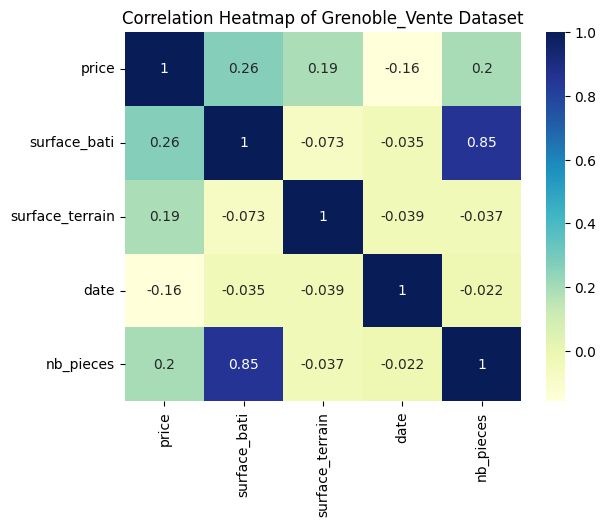

In [19]:
# Compute correlation matrix
corr = df_appartement.corr(numeric_only=True)

# Plot
sns.heatmap(corr, annot=True, cmap="YlGnBu")

plt.title("Correlation Heatmap of Grenoble_Vente Dataset")
# la correlation date/price est plus que celle entre nb_piece/price en valeur absolue donc en la garde
plt.show()

In [22]:
# according to litterature review log(price) ~ log(surface_bati) + log(nb_piece_principale) + date+other variables
# and better if for each category of property type we have a different model
def compute_log_vars(df_in):
    # Keep strictly positive values for log transform
    mask = (df_in['price'] > 0) & (df_in['surface_bati'] > 0) & (df_in['surface_terrain'] > 0)
    df_out = df_in.loc[mask].copy()
    df_out['log_price'] = np.log(df_out['price'])
    df_out['log_surface_bati'] = np.log(df_out['surface_bati'])
    df_out['log_surface_terrain'] = np.log(df_out['surface_terrain'])
    # Also keep a duplicate name for any legacy cells using 'log_price'
    drop_cols = ['price', 'surface_bati', 'surface_terrain', 'type_local']
    df_out = df_out.drop(columns=drop_cols, errors='ignore')

    return df_out


In [23]:
df_appartement_log = compute_log_vars(df_appartement)
df_appartement_log.head()

,date,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,10,2,11.631242,3.806662,0.0
1,8,1,11.082143,3.367296,0.0
3,7,2,11.798104,3.891820,0.0
4,3,1,10.878047,2.639057,0.0
5,2,4,11.225243,4.110874,0.0


In [24]:
df_copy_log = compute_log_vars(df_copy)
df_copy_log.head()

,date,nb_pieces,log_price,log_surface_bati,log_surface_terrain
0,10,2,11.631242,3.806662,0.0
1,8,1,11.082143,3.367296,0.0
3,7,2,11.798104,3.891820,0.0
4,3,1,10.878047,2.639057,0.0
5,2,4,11.225243,4.110874,0.0


In [25]:
def standard_scale_df(df, return_scaler=False):
    """
    Returns a copy of df with all numeric columns standard-scaled (mean=0, std=1).

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame.
    return_scaler : bool, optional (default=False)
        If True, also returns the fitted StandardScaler object.

    Returns
    -------
    df_scaled : pd.DataFrame
        DataFrame with same columns, numeric ones scaled, non-numeric unchanged.
    (optional) scaler : sklearn.preprocessing.StandardScaler
        Fitted scaler, useful for transforming new data later.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame")

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print("No numeric columns found; returning original DataFrame.")
        return (df.copy(), None) if return_scaler else df.copy()

    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

    return (df_scaled, scaler) if return_scaler else df_scaled


In [28]:
#Scaled version
df_appartementScaled = standard_scale_df(df_appartement)
df_appartementScaled_log = standard_scale_df(df_appartement_log)
df_copyScaled = standard_scale_df(df_copy)
df_copyScaled_log = standard_scale_df(df_copy_log)
dataframe_list = [df_appartement, df_appartement_log, df_copy, df_copy_log,
                  df_appartementScaled, df_appartementScaled_log, df_copyScaled, df_copyScaled_log]

In [29]:
import pandas as pd
import statsmodels.formula.api as smf

models = []

for df in dataframe_list:  # (typo fixed from "datadrame_list")
    df = df.copy()

    # Make all column names formula-safe: replace spaces, dots, etc.
    df.columns = df.columns.str.replace('[^0-9a-zA-Z_]+', '_', regex=True)

    target = 'log_price' if 'log_price' in df.columns else 'price'
    if target not in df.columns:
        print("Skipping: target not found")
        continue

    # Build the formula dynamically excluding the target itself
    predictors = [c for c in df.columns if c != target]
    formula = f"{target} ~ " + " + ".join(predictors)

    # Fit model safely
    model = smf.ols(formula=formula, data=df).fit()
    models.append(model)
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     41.70
Date:                Sun, 26 Oct 2025   Prob (F-statistic):           1.71e-32
Time:                        12:21:40   Log-Likelihood:                -14130.
No. Observations:                1062   AIC:                         2.827e+04
Df Residuals:                    1057   BIC:                         2.829e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.244e+05   1.37e+04     